In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 86

df = pd.read_csv('../data/foot_traffic.csv')

df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


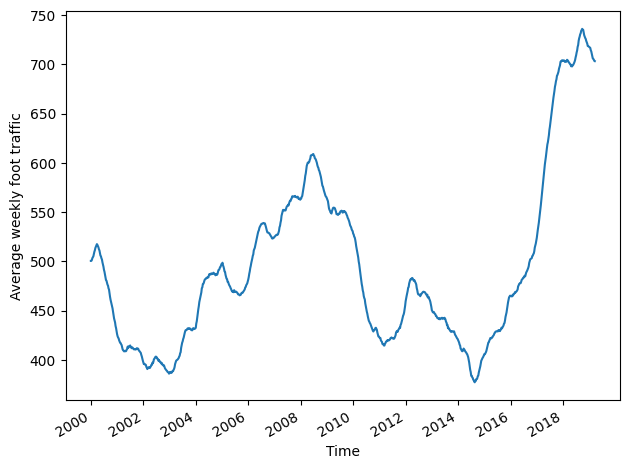

In [3]:
# Figure 5.1 in pg 82 and 
# Figure 5.4 in pg 87

fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F01_peixeiro.png', dpi=300)

We are going to work with train portion of dataset only since the beginning. Later, we will forecast the test portion and measure the forecast error

In [4]:
train = df[:-52]
test = df[-52:]

print(len(train))
print(len(test))

948
52


In [5]:
# Pg 86-87

ADF_result = adfuller(train)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# It shows non-stationarity

ADF Statistic: -1.357794616275116
p-value: 0.602334458170106


In [6]:
# Pg 87

foot_traffic_diff_train = np.diff(train['foot_traffic'], n=1)

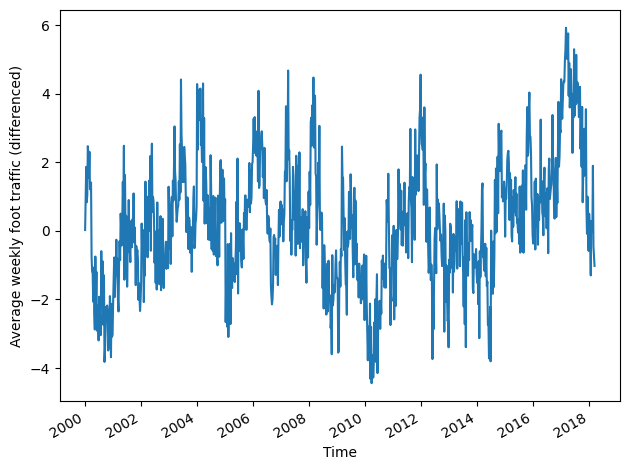

In [7]:
# Figure 5.5 in pg 88

fig, ax = plt.subplots()

ax.plot(foot_traffic_diff_train)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F05_peixeiro.png', dpi=300)

In [8]:
# Pg 88

ADF_result = adfuller(foot_traffic_diff_train)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# It shows stationarity

ADF Statistic: -5.077729493753772
p-value: 1.5538910755362832e-05


First-order differencing makes it stationary. We could use ARIMA d=1

In [9]:
# ARIMA integrated coefficient
d = 1

In [10]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [12]:
result_df = optimize_ARIMA(train['foot_traffic'], order_list, d) # we send the original series, not the differencing
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 3)",2658.013441
1,"(3, 1)",2658.595081
2,"(3, 0)",2658.691777
3,"(2, 1)",2659.873751
4,"(3, 2)",2659.916852
5,"(2, 3)",2659.977855
6,"(3, 3)",2660.802093
7,"(2, 2)",2661.229924
8,"(2, 0)",2667.725827
9,"(1, 2)",2669.719835


Interesting, ARIMA(1,1,3) would be the best model, then ARIMA(3,1,1)   
ARIMA(3,1,0) is very close. Let's look at ACF and PACF

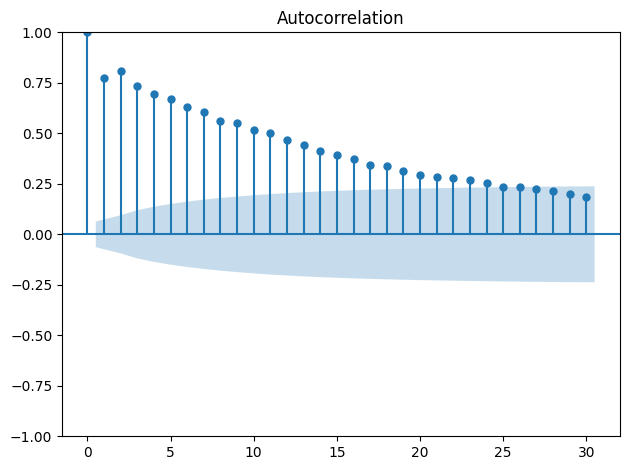

In [13]:
plot_acf(foot_traffic_diff_train, lags=30)

plt.tight_layout()

It does not invite to consider any MA q component

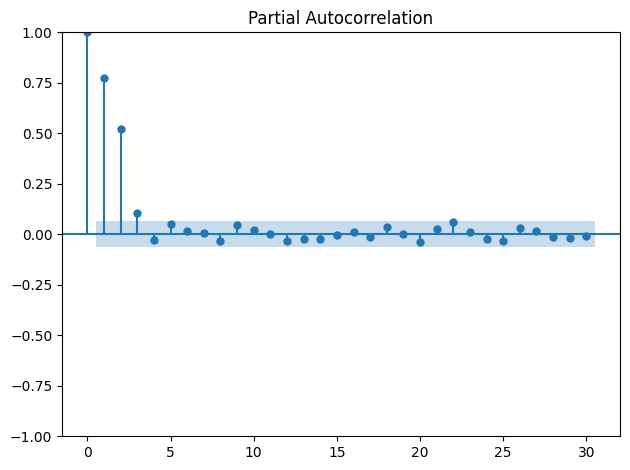

In [14]:
plot_pacf(foot_traffic_diff_train, lags=30)

plt.tight_layout()

It invites to consider AR p component, AR(3)  

I will go with ARIMA(3,1,0). Let's do residual analysis 

In [15]:
model = SARIMAX(train, order=(3,1,0), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           foot_traffic   No. Observations:                  948
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1325.346
Date:                Mon, 09 Feb 2026   AIC                           2658.692
Time:                        00:44:52   BIC                           2678.105
Sample:                             0   HQIC                          2666.090
                                - 948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3165      0.033      9.603      0.000       0.252       0.381
ar.L2          0.4802      0.031     15.510      0.000       0.419       0.541
ar.L3          0.1077      0.034      3.156      0.0

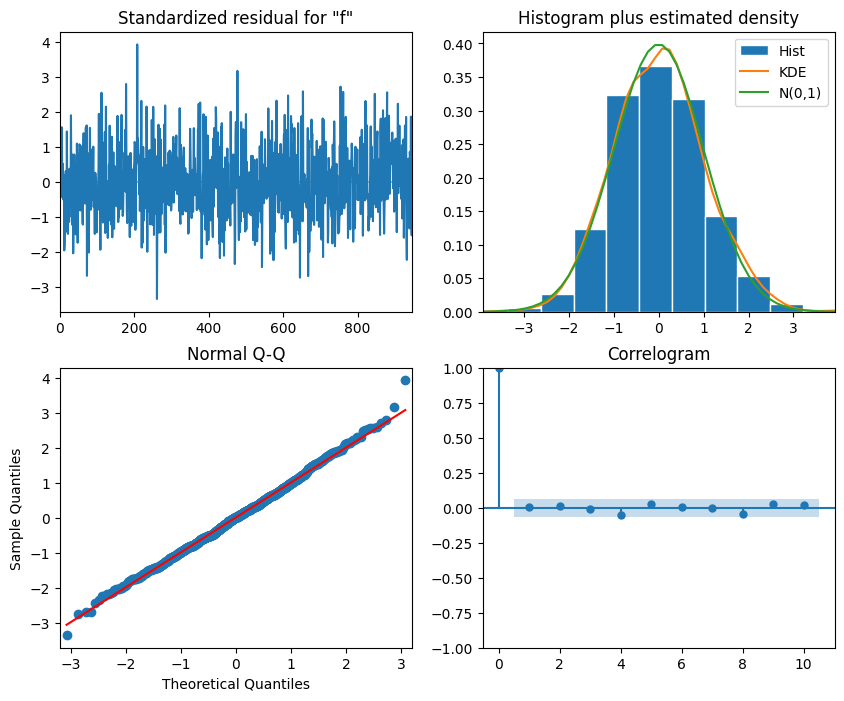

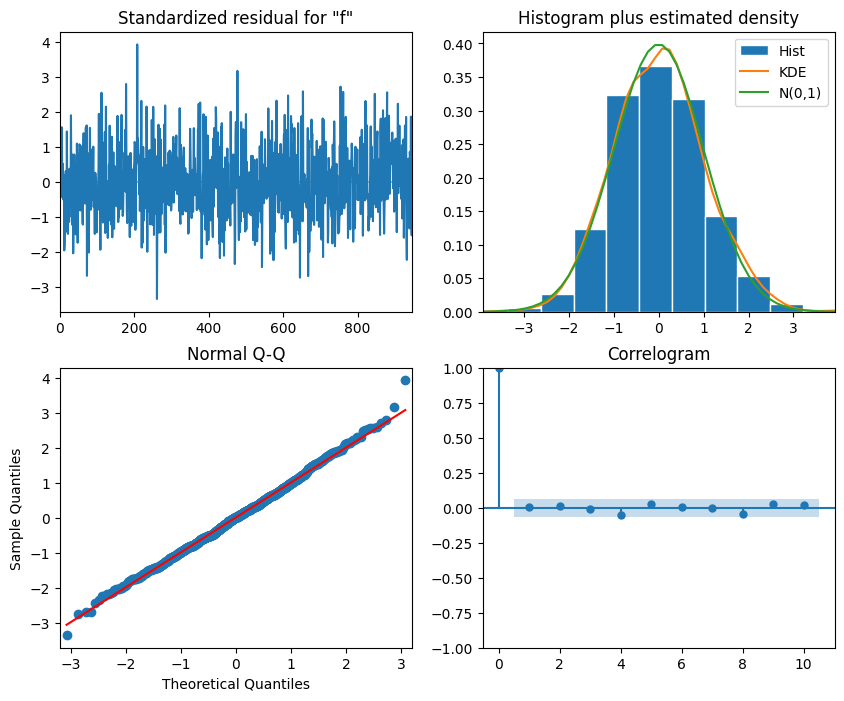

In [16]:
model_fit.plot_diagnostics(figsize=(10,8))

Residuals resemble white noise: normally distributed and uncorrelated

In [17]:
residuals = model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 21, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,5.283646e-07,0.999420
2,2.953440e-03,0.998524
3,1.120838e-02,0.999685
4,1.156744e-02,0.999983
5,1.171482e-02,0.999999
6,2.057364e-02,1.000000
7,2.283018e-02,1.000000
8,2.393564e-02,1.000000
9,2.501986e-02,1.000000
10,2.585504e-02,1.000000


Residuals are uncorrelated

### Model ready for forecast

In [18]:
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})

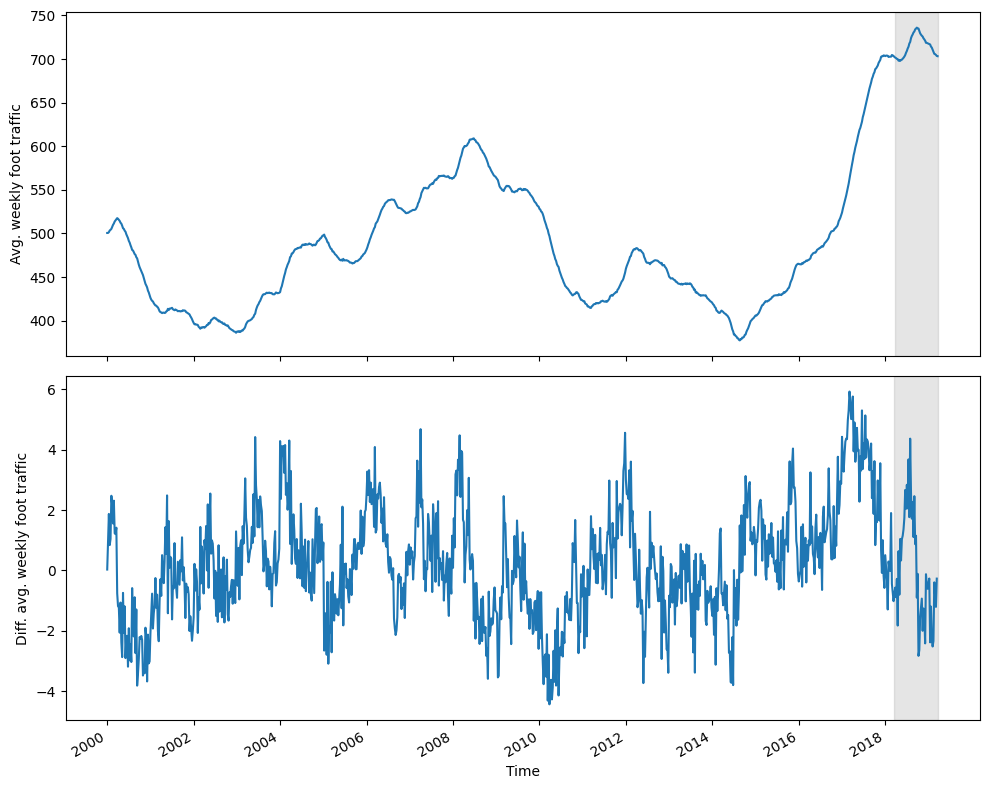

In [19]:
# Pg 93
# Figure 5.9 in pg 94

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Avg. weekly foot traffic')
ax1.axvspan(948, 1000, color='#808080', alpha=0.2)

ax2.plot(df_diff['foot_traffic_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Diff. avg. weekly foot traffic')
ax2.axvspan(947, 999, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH05_F09_peixeiro.png', dpi=300)

In [20]:
#def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
def rolling_forecast(df: pd.Series, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1]#.values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(i, i + window - 1)   # changed from (0, i + window - 1) to (i, i + window - 1), no need to calculate them all
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [21]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 #2

pred_mean = rolling_forecast(df['foot_traffic'], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df['foot_traffic'], TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df['foot_traffic'], TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARIMA'] = pred_ARIMA

pred_df.head()

,foot_traffic,pred_mean,pred_last_value,pred_ARIMA
948,701.686830,481.204906,702.463430,701.743717
949,701.112198,481.437237,701.686830,700.872282
950,700.221501,481.668474,701.112198,700.447460
951,699.937948,481.898288,700.221501,699.580032
952,698.107264,482.127321,699.937948,699.358669


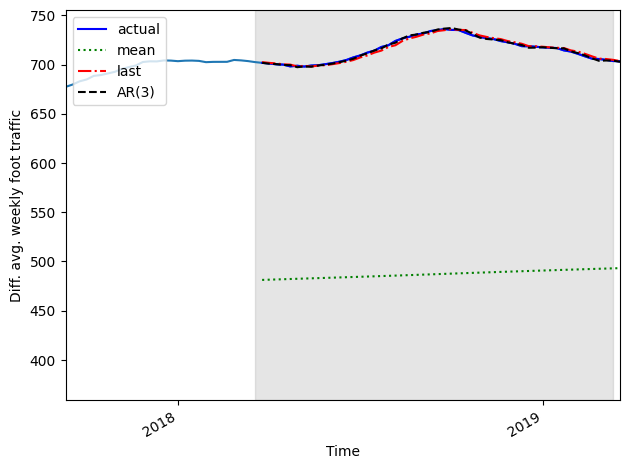

In [25]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(pred_df['foot_traffic'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARIMA'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Diff. avg. weekly foot traffic')

ax.axvspan(947, 998, color='#808080', alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['foot_traffic'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['foot_traffic'], pred_df['pred_last_value'])
mse_ARIMA = mean_squared_error(pred_df['foot_traffic'], pred_df['pred_ARIMA'])

print(mse_mean, mse_last, mse_ARIMA)

52086.252587374445 3.0680952615237675 0.924248457711192


In [27]:
df['pred_foot_traffic'] = pred_df['pred_ARIMA']

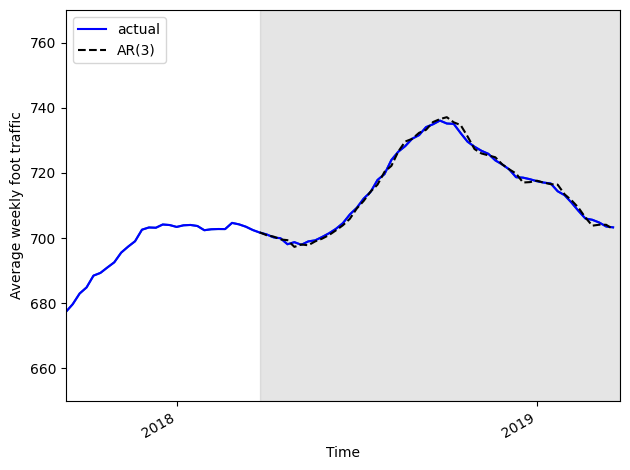

In [28]:
fig, ax = plt.subplots()

ax.plot(df['foot_traffic'])
ax.plot(df['foot_traffic'], 'b-', label='actual')
ax.plot(df['pred_foot_traffic'], 'k--', label='AR(3)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

ax.axvspan(948, 1000, color='#808080', alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988],[2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [29]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])

print(mae_AR_undiff)

0.7524469221021902


Mean Absolute Error of 0.75  
Predictions of weekly foot traffic are off by 0.75 people on average 

As obtained in CH05_cumsum_error.ipynb